In [10]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from smartredis import Client
from smartsim import Experiment
import skopt

In [12]:
# Reduce logging noise
os.environ['SMARTSIM_LOG_LEVEL'] = 'quiet'

# Path to simpleFoam executable (verify yours is correct)
SIMPLEFOAM_PATH = "/usr/lib/openfoam/openfoam2412/platforms/linux64GccDPInt32Opt/bin/simpleFoam"

# Parameter names and default values (from pitzDaily)
param_names = ['epsilon', 'Cmu', 'C1', 'C2']
default_values = [14.855, 0.09, 1.44, 1.92]

# Optimization bounds
bounds = [
    [default_values[0] * 0.2, default_values[0] * 5],
    [0.05, 0.15],
    [1.0, 1.5],
    [1.5, 3.0],
]


In [13]:
# Sigma epsilon formula (dependent parameter)
def calculate_sigma_epsilon(Cmu, C2, C1, kappa=0.375):
    return np.sqrt(kappa) / (np.sqrt(Cmu) * (C2 - C1))

# Create main experiment
exp = Experiment("Tune_K_Epsilon")

# ====== Run baseline simulation to compare ======
default_sigma_epsilon = calculate_sigma_epsilon(default_values[1], default_values[3], default_values[2])
rs = exp.create_run_settings(SIMPLEFOAM_PATH)

unique_model_name = f"default_simulation_{int(time.time())}"
default_simulation = exp.create_model(unique_model_name, rs)
default_simulation.params = {
    'epsilon': default_values[0],
    'Cmu': default_values[1],
    'C1': default_values[2],
    'C2': default_values[3],
    'sigmaEps': default_sigma_epsilon
}
default_simulation.attach_generator_files(to_configure="pitzDaily")
exp.generate(default_simulation, overwrite=True, tag="!")
exp.start(default_simulation, block=True)


10:15:17 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING default_simulation_1749617114(855671): SmartSimStatus.STATUS_FAILED
10:15:17 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING default_simulation_1749617114 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/default_simulation_1749617114


In [14]:
# ====== Function to extract the objective value ======
def extract_output(model, true_p=1.9):
    fname = os.path.join(model.path, "postProcessing/avgInlets/0/surfaceFieldValue.dat")
    try:
        data = np.loadtxt(fname, skiprows=5)
        error = (true_p + data[-1, 1])**2
        return error if error < 1e3 else np.nan
    except Exception as e:
        print(f"Failed to extract output from {fname} — {e}")
        return np.nan

# ====== Objective function for optimizer ======
def evaluate_function(values):
    nparams = len(values[0])
    params = {}
    for i in range(nparams):
        params[param_names[i]] = [v[i] for v in values]

    # Add derived sigmaEps
    params['sigmaEps'] = [
        calculate_sigma_epsilon(params['Cmu'][i], params['C2'][i], params['C1'][i])
        for i in range(len(values))
    ]

    rs = exp.create_run_settings(SIMPLEFOAM_PATH)

    unique_eval_name = f"evaluation_{int(time.time())}"
    ens = exp.create_ensemble(unique_eval_name, params=params, perm_strategy="step", run_settings=rs)
    ens.attach_generator_files(to_configure="pitzDaily")
    exp.generate(ens, overwrite=True, tag="!")
    exp.start(ens, block=True)

    # Extract errors
    outputs = []
    for model in ens.models:
        err = extract_output(model)
        outputs.append(err)

    return outputs[0] if len(outputs) == 1 else outputs


In [15]:
 #====== Bayesian Optimization Loop ======
optimizer = skopt.Optimizer(
    dimensions=bounds,
    random_state=1,
    base_estimator='gp'
)

# Main loop
for iteration in range(10):
    x = optimizer.ask(n_points=5)
    y = evaluate_function(x)

    x = np.array(x)
    y = np.array(y)
    valid = np.isfinite(y) & (y < 1e20)

    x = x[valid, :]
    y = y[valid]

    optimizer.tell(x.tolist(), y.tolist())
    min_idx = np.argmin(optimizer.yi)

    print("\nParameter     \tDefault\tOptimal\tMin\tMax")
    for i in range(len(param_names)):
        print(f"{param_names[i]}:\t{default_values[i]:.4f}\t{optimizer.Xi[min_idx][i]:.4f}\t{bounds[i][0]:.4f}\t{bounds[i][1]:.4f}")
    print(f"Error:     \t{np.sqrt(optimizer.yi[min_idx]):.4e}")

# ====== Final Comparison ======
default_accuracy = extract_output(default_simulation)
min_idx = np.argmin(optimizer.yi)

print("\nFinal Results")
print("Parameter     \tDefault\tOptimal\tMin\tMax")
for i in range(len(param_names)):
    print(f"{param_names[i]}:\t{default_values[i]:.4f}\t{optimizer.Xi[min_idx][i]:.4f}\t{bounds[i][0]:.4f}\t{bounds[i][1]:.4f}")
print("-" * 40)
print(f"Default Error: \t{np.sqrt(default_accuracy):.4f}")
print(f"Optimal Error: \t{np.sqrt(optimizer.yi[min_idx]):.4e}")




10:16:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617159_0(855717): SmartSimStatus.STATUS_FAILED
10:16:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617159_0 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617159/evaluation_1749617159_0
10:16:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617159_1(855721): SmartSimStatus.STATUS_FAILED
10:16:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617159_1 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617159/evaluation_1749617159_1
10:16:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WA

/tmp/ipykernel_854869/4168779708.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(kappa) / (np.sqrt(Cmu) * (C2 - C1))


10:16:34 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617188_0(855848): SmartSimStatus.STATUS_FAILED
10:16:34 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617188_0 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617188/evaluation_1749617188_0
10:16:34 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617188_1(855852): SmartSimStatus.STATUS_FAILED
10:16:34 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617188_1 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617188/evaluation_1749617188_1
10:16:34 cfdm-MS-7A15 SmartSim[854869:JobManager] WA

/home/cfdm/anaconda3/envs/clean_bo_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


10:16:54 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617209_0(855939): SmartSimStatus.STATUS_FAILED
10:16:54 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617209_0 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617209/evaluation_1749617209_0
10:16:54 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617209_1(855943): SmartSimStatus.STATUS_FAILED
10:16:54 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617209_1 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617209/evaluation_1749617209_1
10:16:54 cfdm-MS-7A15 SmartSim[854869:JobManager] WA

/home/cfdm/anaconda3/envs/clean_bo_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/tmp/ipykernel_854869/4168779708.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(kappa) / (np.sqrt(Cmu) * (C2 - C1))


10:17:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617219_0(855986): SmartSimStatus.STATUS_FAILED
10:17:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617219_0 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617219/evaluation_1749617219_0
10:17:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617219_1(855990): SmartSimStatus.STATUS_FAILED
10:17:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617219_1 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617219/evaluation_1749617219_1
10:17:05 cfdm-MS-7A15 SmartSim[854869:JobManager] WA

/tmp/ipykernel_854869/4168779708.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(kappa) / (np.sqrt(Cmu) * (C2 - C1))


10:17:37 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617251_0(856123): SmartSimStatus.STATUS_FAILED
10:17:37 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617251_0 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617251/evaluation_1749617251_0
10:17:37 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617251_1(856127): SmartSimStatus.STATUS_FAILED
10:17:37 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING evaluation_1749617251_1 failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/evaluation_1749617251/evaluation_1749617251_1
10:17:37 cfdm-MS-7A15 SmartSim[854869:JobManager] WA

In [16]:
# Run a final simulation with optimized parameters
best_params = optimizer.Xi[np.argmin(optimizer.yi)]
optimal_sigma_eps = calculate_sigma_epsilon(best_params[1], best_params[3], best_params[2])

rs = exp.create_run_settings(SIMPLEFOAM_PATH)
final_model = exp.create_model("final_optimized", run_settings=rs)
final_model.params = {
    "epsilon": best_params[0],
    "Cmu": best_params[1],
    "C1": best_params[2],
    "C2": best_params[3],
    "sigmaEps": optimal_sigma_eps
}
final_model.attach_generator_files(to_configure="pitzDaily")
exp.generate(final_model, overwrite=True, tag="!")
exp.start(final_model, block=True)

final_error = extract_output(final_model)

print("\n✅ Final optimized simulation done!")
print(f"Optimized parameters: {dict(zip(param_names, best_params))}")
print(f"Final error: {np.sqrt(final_error):.4f}")
import matplotlib.pyplot as plt


10:19:00 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING final_optimized(856245): SmartSimStatus.STATUS_FAILED
10:19:00 cfdm-MS-7A15 SmartSim[854869:JobManager] WARNING final_optimized failed. See below for details 
Job status at failure: SmartSimStatus.STATUS_FAILED 
Launcher status at failure: Failed 
Job returncode: 1 
Error and output file located at: /home/cfdm/OpenFOAM_Opt/pitzDaily_opt/Tune_K_Epsilon/final_optimized

✅ Final optimized simulation done!
Optimized parameters: {'epsilon': 53.07239854125257, 'Cmu': 0.05616517318142233, 'C1': 1.1884459380869283, 'C2': 1.7184650930962762}
Final error: 1.9000


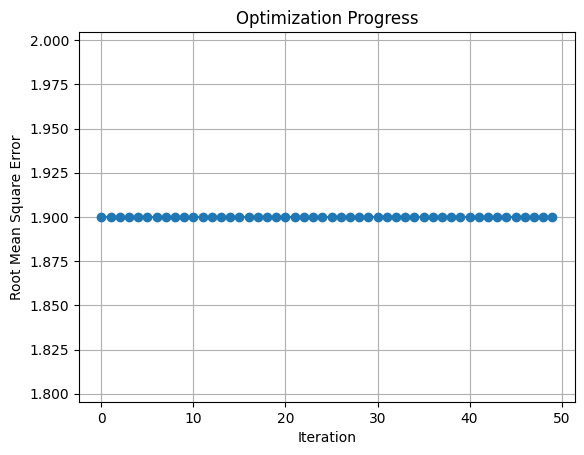

✅ Results saved to optimization_results.csv


In [17]:
plt.figure()
plt.plot(np.sqrt(optimizer.yi), marker='o')
plt.title("Optimization Progress")
plt.xlabel("Iteration")
plt.ylabel("Root Mean Square Error")
plt.grid(True)
plt.savefig("optimization_progress.png", dpi=300)
plt.show()
import pandas as pd

results_df = pd.DataFrame(optimizer.Xi, columns=param_names)
results_df["error"] = np.sqrt(optimizer.yi)
#results_df.to_csv("optimization_results.csv", index=False)
print("✅ Results saved to optimization_results.csv")
